## Plane Delays & Calculations

After the data cleaning process done in , let's go ahead with the analysis!

### CRISP-DM Framework

* Business Problem: 
* Data Understanding: What the data set is
* Data Preparation: All Data Cleaning, inc treatment of missing Data, NaNs, zeros, transforms
* Modelling: The Modelling Workflow, models used and feature transforms / engineering
* Evaulation: Evaluation of the Final Model vs Baseline Model
* Deployment: Results generated by the model

### CRISP-DM Framework: Business Problem:
* Identify Factors that could help Reduce Flight Cancellations / Delays for intenal US departing from Wisconsin.
* Save money / stress, etc.

### What the data set is:

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

The dataset was sourced from Kaggle.

https://www.kaggle.com/usdot/flight-delays

In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [3]:
df = pd.read_csv('wisconsin.csv')
df.head(2)
df.drop(df.columns[0], axis=1, inplace=True)

In [4]:
# all years are 2015
del df['YEAR']

In [5]:
df.head(1)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,OO,3423,N170SY,MKE,SEA,1605,1603.0,-2.0,11.0,1614.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931


In [6]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE'],
      dtype='object')

In [7]:
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].replace('nan', np.nan).fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].replace('nan', np.nan).fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].replace('nan', np.nan).fillna(0)
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].replace('nan', np.nan).fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].replace('nan', np.nan).fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].replace('nan', np.nan).fillna(0)
df['TAXI_OUT'] = df['TAXI_OUT'].replace('nan', np.nan).fillna(0)
df['WHEELS_OFF'] = df['WHEELS_OFF'].replace('nan', np.nan).fillna(0)
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].replace('nan', np.nan).fillna(0)
df['AIR_TIME'] = df['AIR_TIME'].replace('nan', np.nan).fillna(0)
df['WHEELS_ON'] = df['WHEELS_ON'].replace('nan', np.nan).fillna(0)
df['TAXI_IN'] = df['TAXI_IN'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].replace('nan', np.nan).fillna(0)

In [8]:
df['DELAYED_TARGET'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)

In [9]:
# delayed = df[df['DEPARTURE_DELAY'] > 0]
# delayed
df.head(2)
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE', 'DELAYED_TARGET'],
      dtype='object')

# Dataset exploration

## Visual exploration

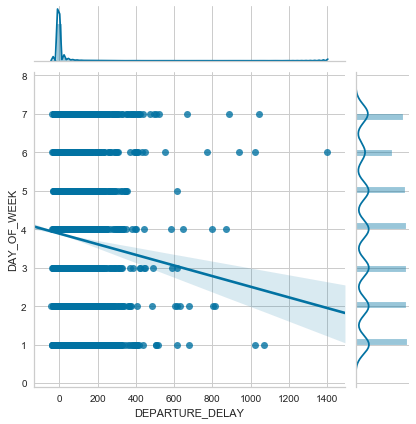

In [10]:
sns.jointplot('DEPARTURE_DELAY','DAY_OF_WEEK', data=df, kind='reg');

# Feature selection

In [13]:
features = ['MONTH',                    
            'DAY',                      
            'DAY_OF_WEEK',                 
            'SCHEDULED_DEPARTURE',            
            'DISTANCE',
            'DELAYED_TARGET',
            ]

#'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
 #      'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
  #     'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
   #    'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    #   'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
     #  'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
      # 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       #'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
#       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
 #      'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
  #     'DESTINATION_LONGITUDE'

target = df['DEPARTURE_DELAY']
dff = df[features].copy()
sns.heatmap(dffeatures.corr(), center=0, annot=True);

NameError: name 'dffeatures' is not defined

In [15]:
dff.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DISTANCE,DELAYED_TARGET
0,7,1,3,1605,1694,0
1,7,2,4,1605,1694,0
2,7,3,5,1605,1694,0
3,7,4,6,1605,1694,0
4,7,5,7,1605,1694,0


### Class Imbalance

In [16]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
df['DELAYED_TARGET'].value_counts()

0    37545
1    13831
Name: DELAYED_TARGET, dtype: int64

In [18]:
y = df['DELAYED_TARGET']
X = dff.drop(columns=['DELAYED_TARGET'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    28159
1    10373
Name: DELAYED_TARGET, dtype: int64


0    9386
1    3458
Name: DELAYED_TARGET, dtype: int64


AUC: 0.5785862883289622


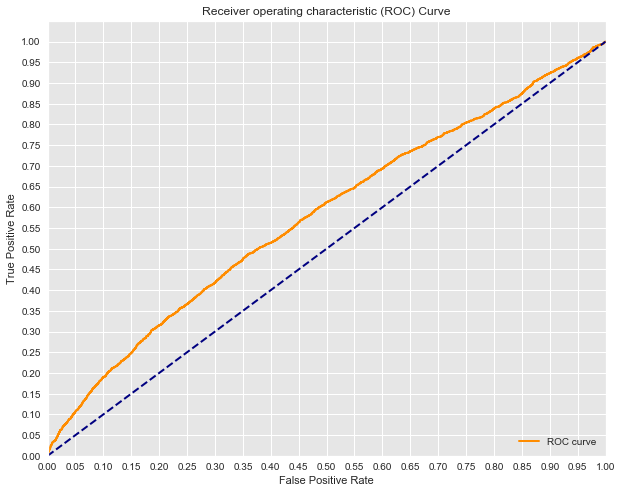

In [20]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9320 3368]
 [  66   90]]


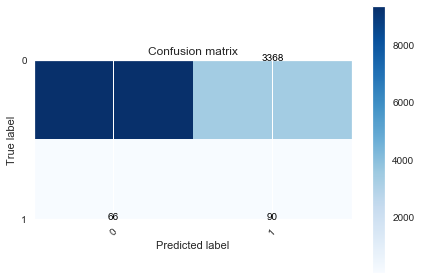

In [22]:
# Plot confusion matrix of the test set 
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5780029280777876
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.5785299364804675
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
         

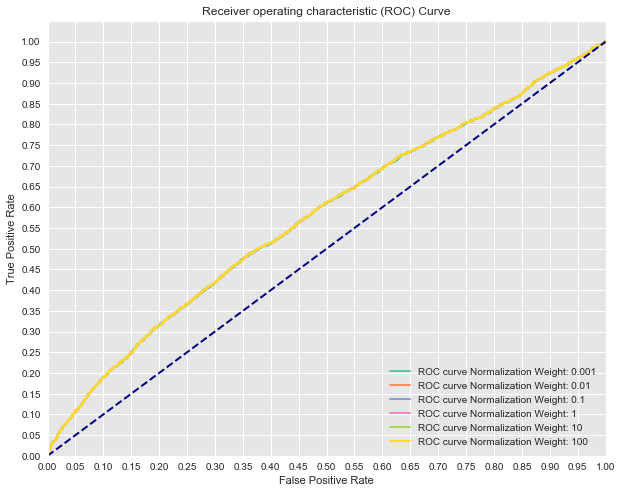

In [23]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

In [24]:
# Use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    28159
1    10373
Name: DELAYED_TARGET, dtype: int64


1    28159
0    28159
Name: DELAYED_TARGET, dtype: int64


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.6222708944581947
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.6222391907665047
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

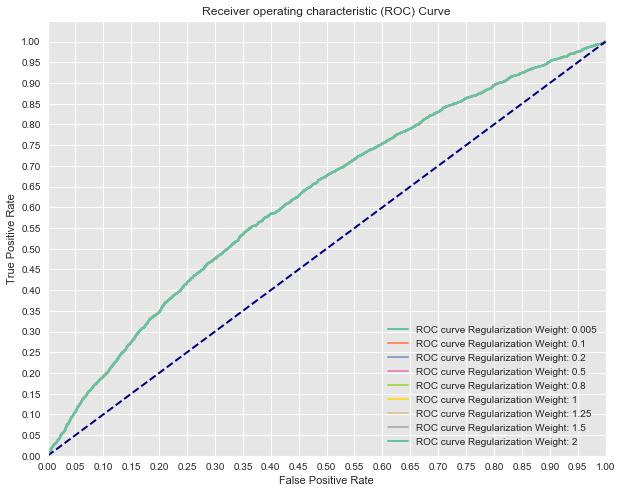

In [25]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Logistic Regression

In [26]:
import numpy as np

def predict_y(X, w):
    return np.dot(X,w)

In [27]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1 + np.e**(-1*x))

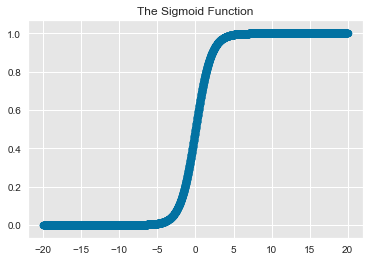

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot sigmoid
x = np.linspace(start=-20, stop=20, num=10**4)
y = [sigmoid(xi) for xi in x]
plt.scatter(x, y)
plt.title('The Sigmoid Function')
plt.show()

In [29]:
# Your code here
def grad_desc(X, y, max_iterations, alpha, initial_weights=None):
    """Be sure to set default behavior for the initial_weights parameter."""
    if initial_weights == None:
        initial_weights = np.ones((X.shape[1],1)).flatten()
    weights_col= pd.DataFrame(initial_weights)
    weights = initial_weights
    # Create a for loop of iterations
    for iteration in range(max_iterations):
        # Generate predictions using the current feature weights
        predictions = sigmoid(np.dot(X,weights))
        # Calculate an error vector based on these initial predictions and the correct labels
        error_vector = y - predictions
        # Calculate the gradient 
        # As we saw in the previous lab, calculating the gradient is often the most difficult task.
        # Here, your are provided with the closed form solution for the gradient of the log-loss function derived from MLE
        # For more details on the derivation, see the additional resources section below.
        gradient = np.dot(X.transpose(),error_vector)
        # Update the weight vector take a step of alpha in direction of gradient 
        weights += alpha * gradient
        weights_col = pd.concat([weights_col, pd.DataFrame(weights)], axis=1)
    # Return finalized weights
    return weights, weights_col

In [30]:
import pandas as pd
# df = pd.read_csv('wisconsin.csv')

# Create the predictor and target variables

y = dff['DELAYED_TARGET']
X = dff.drop(columns=['DELAYED_TARGET'], axis=1)

print(y.value_counts())
X.head()

0    37545
1    13831
Name: DELAYED_TARGET, dtype: int64


,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DISTANCE
0,7,1,3,1605,1694
1,7,2,4,1605,1694
2,7,3,5,1605,1694
3,7,4,6,1605,1694
4,7,5,7,1605,1694


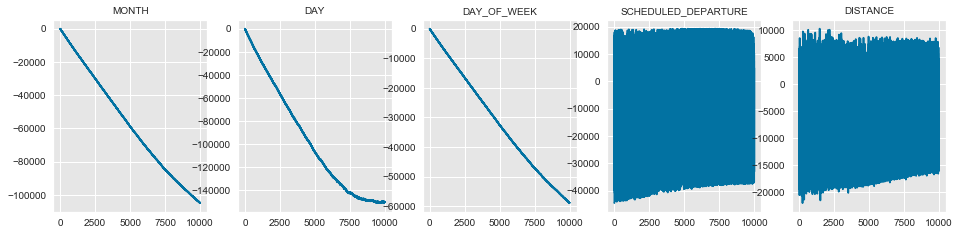

In [31]:
weights, weight_col = grad_desc(X, y, 10000, 0.001)
weight_col.columns = np.arange(len(weight_col.columns))

plt.figure(figsize=(16, 12))

for (i, j) in enumerate(weights):
    plt.subplot(3, 5, i + 1)
    plt.title(list(X)[i], size='medium')
    plt.plot(weight_col.iloc[i].T)
    plt.axis('tight')

## Scikit-learn

In [32]:
# Your code here
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e16, random_state=2, solver='liblinear')
logreg.fit(X, y)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Your code here
print("Scikit-learn's weights:", logreg.coef_[0])
print("Our manual regression weights:", weights)

Scikit-learn's weights: [-8.51307247e-02 -2.30349290e-02 -1.26746910e-01  3.07666614e-04
  9.58507901e-05]
Our manual regression weights: [-104843.1406359  -149742.22139303  -58853.34231989    4825.28861827
    2373.77344579]


Coefficient weights:
 [ -6309.88189829 -12609.5469046   -3464.58587167  -7378.91790998
  -4348.99948037]


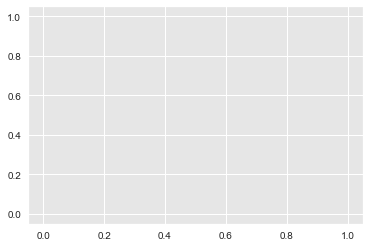

In [40]:
# Your code here
import matplotlib.pyplot as plt
%matplotlib inline

def grad_desc(X, y, max_iterations, alpha, initial_weights=None):
    """Be sure to set default behavior for the initial_weights parameter."""
    if initial_weights == None:
        initial_weights = np.ones((X.shape[1],1)).flatten()
    weights = initial_weights
    costs = []
    # Create a for loop of iterations
    for iteration in range(max_iterations):
        # Generate predictions using the current feature weights
        predictions = sigmoid(np.dot(X,weights))
        # Calculate an error vector based on these initial predictions and the correct labels
        error_vector = y - predictions
        # Calculate the gradient (transpose of X times error is the gradient)
        gradient = np.dot(X.transpose(),error_vector)
        # Update the weight vector take a step of alpha in direction of gradient 
        weights += alpha * gradient
        # Calculate the cost
        cost = ((-y * np.log(predictions))-((1-y)* np.log(1-predictions))).mean()
        costs.append(cost)
    # Return finalized Weights
    return weights, costs

max_iterations = 500
weights, costs = grad_desc(X, y, max_iterations, 0.001)
print('Coefficient weights:\n', weights)
plt.plot(range(max_iterations), costs)
plt.show()

## Logistic Regression Grid Search

### Grid Search CV

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [36]:
y = df['DELAYED_TARGET']
X = dff.drop(columns=['DELAYED_TARGET'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 65.56%


## Hyper Parameter Optimisation

In [41]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [42]:
num_decision_trees = 3 * 2 * 6 * 3 * 6
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 648 different permutations.


In [43]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [44]:
GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
 

In [45]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 75.40%
Mean Test Score: 73.10%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

### what was the outcome?

In [46]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 73.71%


In [ ]:
### Tuning more advanced models: Random forests

In [47]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [48]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 75.08%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}


In [49]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.7310028028651511
Random forest grid search:  0.7499221426346933


### Gradient Boosting and Weak Learners

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [53]:
# Print the first five rows
dff.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DISTANCE,DELAYED_TARGET
0,7,1,3,1605,1694,0
1,7,2,4,1605,1694,0
2,7,3,5,1605,1694,0
3,7,4,6,1605,1694,0
4,7,5,7,1605,1694,0


In [54]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [55]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [56]:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [57]:
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [58]:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [59]:
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

In [60]:
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [61]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.7310806602304578
F1-Score: 0.04953219592735277

Model: Gradient Boosted Trees
Accuracy: 0.7396449704142012
F1-Score: 0.11596757137821642

Testing Metrics
Model: AdaBoost
Accuracy: 0.7317035191529119
F1-Score: 0.052255225522552254

Model: Gradient Boosted Trees
Accuracy: 0.7401121146060418
F1-Score: 0.1159957627118644


In [62]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[9303,   93],
       [3353,   95]], dtype=int64)

In [63]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      9396
           1       0.51      0.03      0.05      3448

    accuracy                           0.73     12844
   macro avg       0.62      0.51      0.45     12844
weighted avg       0.67      0.73      0.63     12844



In [67]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, df, target, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
nan


In [68]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, df, target, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
nan


### Support Vector Machines

#### Decision Tree Analysis
#### Work-in-progress will go here

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [ ]:
# remove minutes from departure time 
dff['SCHEDULED_DEPARTURE'].floordiv(100)

In [ ]:
dff.head()
dff.info()

In [ ]:
# setting up the problem
X = dff.drop('DELAYED_TARGET', axis=1)  
X = dff.drop('SCHEDULED_DEPARTURE', axis=1)
y = dff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# One-hot encode the training data and show the resulting DataFrame with proper column names
ohe = OneHotEncoder()

In [ ]:
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

In [ ]:
# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

In [ ]:
ohe_df.head()
# Train the decision tree
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [ ]:
# Plot the decision tree
clf.fit(X_train_ohe, y_train)

In [ ]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

In [ ]:
# Draw graph
graph = graph_from_dot_data(dot_data)  

In [ ]:
# Show graph
Image(graph.create_png())
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

In [ ]:
print('Accuracy: ', accuracy_score(y_test, y_preds))
col_2 = ohe_df[ohe_df.columns[2],[1050]].unique()
col_1

In [ ]:
z = dff.drop('DELAYED_TARGET', axis=1)
z
a = dff['DELAYED_TARGET']
a

In [ ]:
features = X.columns
target = y
target
In [ ]:
# from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = dff.drop('DELAYED_TARGET', axis=1)
y = dff['DELAYED_TARGET']

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)
In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                feature_names=features,
                class_names=y, 
                rounded=True, 
                filled=True)

### Support Vector Machines

In [ ]:
### let's try some svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
dff = df.iloc[:50000].copy()
del dff['AIRLINE']
del dff['TAIL_NUMBER']
del dff['ORIGIN_AIRPORT']
del dff['DESTINATION_AIRPORT']
del dff['airline_full_name']
del dff['ORIGIN_CITY']
del dff['ORIGIN_STATE']
del dff['DESTINATION_CITY']
del dff['DESTINATION_STATE']


dff.head(2)
#df2.DELAYED_TARGET.value_counts()

In [ ]:
#del dff['FLIGHT_NUMBER']
#del dff['DEPARTURE_TIME']
#del dff['DEPARTURE_DELAY']
del dff['WHEELS_OFF']
dff.head()

In [ ]:
dff.describe()
# sub sampling from the class to get around class imbalance issue 1/3 : 2/3 split

In [ ]:
# setting up the problem
X = dff.drop('DELAYED_TARGET', axis=1)  
y = dff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='linear') #, C=0.1, cache_size=100)  
svclassifier.fit(X_train, y_train)

In [ ]:
y_pred = svclassifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

In [12]:
## Bigger sample size / load for analytics
# dff_5000 = dfFeatures.iloc[:5000]
# setting up the problem
#        X = dff_5000.drop('DELAYED_TARGET', axis=1)  
# y = dff_5000['DELAYED_TARGET'] 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
# from sklearn.svm import SVC 
# svclassifier = SVC(kernel='linear') #, C=0.1, cache_size=100)  
# svclassifier.fit(X_train, y_train)
# y_pred = svclassifier.predict(X_test)
# from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
# print(confusion_matrix(y_test,y_pred))  
# print(classification_report(y_test,y_pred)) 
# print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

In [ ]:
# del dff['DAY']
dff.head(1)

## Decision Tree Analysis
Work-in-progress will go here

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [ ]:
dff.head()

In [ ]:
# setting up the problem
X = dff.drop('DELAYED_TARGET', axis=1)  
y = dff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# One-hot encode the training data and show the resulting DataFrame with proper column names
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.head()

## Train the decision tree

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)

clf.fit(X_train_ohe, y_train)

## Plot the decision tree

In [ ]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())


In [ ]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

In [ ]:
z = dff.drop('DELAYED_TARGET', axis=1)
z
a = dff['DELAYED_TARGET']
a

In [ ]:
features = X.columns
target = y
target

In [ ]:
# from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = dff.drop('DELAYED_TARGET', axis=1)
y = dff['DELAYED_TARGET']

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                feature_names=features,
                class_names=y, 
                rounded=True, 
                filled=True)

### Class Imbalance

### Class Imbalance Lab

# Baseline model

In [ ]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

## Linear regression model generation

In [ ]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

## Evaluating the baseline model

In [ ]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

As we can see above, our Rsquared value is just above 0.5 for our train dataset and just below 0.5 for our test dataset. This means the model fits the training dataset slighlty better than the test one. However, as we are using a Kfold method, the test dataset is a portion of the training dataset and each portion - or fold - is used sequentially as the test dataset. The 0.49 value is an average of those iterations.

In [ ]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

In [ ]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

In [ ]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();






This graph tells us we have excelled ourselves lol

# Overfitting the model

In this section, we are going to polynomise our train dataset in order to maximise the Rsquared value (the goodness of fit indicator). We've tried all integers up to 5 (Rsquared = 1) but a cubic transformation brings a 0.64 Rsquare value which is more than enough considering the feature expansion trade-off. (considering our 10 variables, a third degree polynomial means we have about 286 features and interactions to analyse, a fourth degree brings us to 1001!)